Import packages 


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style("whitegrid")

In [36]:
#Read data
bridge = pd.read_csv('./CoverMyMeds_data/bridge.csv')
dim_claims = pd.read_csv('./CoverMyMeds_data/dim_claims.csv')
dim_date = pd.read_csv('./CoverMyMeds_data/dim_date.csv')
dim_pa = pd.read_csv('./CoverMyMeds_data/dim_pa.csv')

In [106]:
#Claim data Summary
for bin_id in dim_claims.bin.unique():
    for drug in dim_claims.drug.unique():
        claim_filtered = dim_claims.loc[(dim_claims['bin']==bin_id) & (dim_claims['drug']==drug)]
        print(f"\n Summary for claim data of drug {drug} with payer {bin_id}")
        print(claim_filtered[['pharmacy_claim_approved', 'reject_code']].fillna(0).value_counts())
    
        


 Summary for claim data of drug A with payer 417380
pharmacy_claim_approved  reject_code
0                        75.0           88486
dtype: int64

 Summary for claim data of drug B with payer 417380
pharmacy_claim_approved  reject_code
1                        0.0            39952
0                        76.0            4419
dtype: int64

 Summary for claim data of drug C with payer 417380
pharmacy_claim_approved  reject_code
0                        70.0           40674
dtype: int64

 Summary for claim data of drug A with payer 999001
pharmacy_claim_approved  reject_code
1                        0.0            293040
0                        76.0            32492
dtype: int64

 Summary for claim data of drug B with payer 999001
pharmacy_claim_approved  reject_code
1                        0.0            148286
0                        76.0            16372
dtype: int64

 Summary for claim data of drug C with payer 999001
pharmacy_claim_approved  reject_code
1                      

We get the following result for each payer:
- payer 417740 never approves claim for drug A or C
- payer 999001 could approve claim for all three drugs
- payer 417740 never approves claim for drug B or C
- payer 417614 never approves claim for drug A or C 


In [37]:
dim_claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,NaN,1
2,3,417740,A,76.0,0
3,4,999001,A,NaN,1
4,5,417740,A,NaN,1


## Logistic regression for Claim approvals:
 Features: 
 - bin numbers (4 different payers)
 - drug types (3 different drugs)
 - date?
    - method 1: use date as a stand alone Feature
    - method 2: separate data set according to date 
 
 


In [38]:
from sklearn.model_selection import train_test_split


In [60]:
X = pd.get_dummies(data=dim_claims[['bin', 'drug']], columns=['bin', 'drug']).to_numpy()
Y = dim_claims['pharmacy_claim_approved'].to_numpy()

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=614, shuffle=True, stratify= Y)

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
log_reg = LogisticRegression()

In [64]:
log_reg.fit(X_train, Y_train)

LogisticRegression()

In [65]:
from sklearn.metrics import accuracy_score
X_train_prob = log_reg.predict_proba(X_train)[:,1]


In [66]:
cutoffs =  np.arange(0,1.01,.01)
accs = []

for cutoff in cutoffs:
    Y_train_pred = 1*(X_train_prob>cutoff)
    accs.append(np.sum(Y_train_pred==Y_train)/len(Y_train))


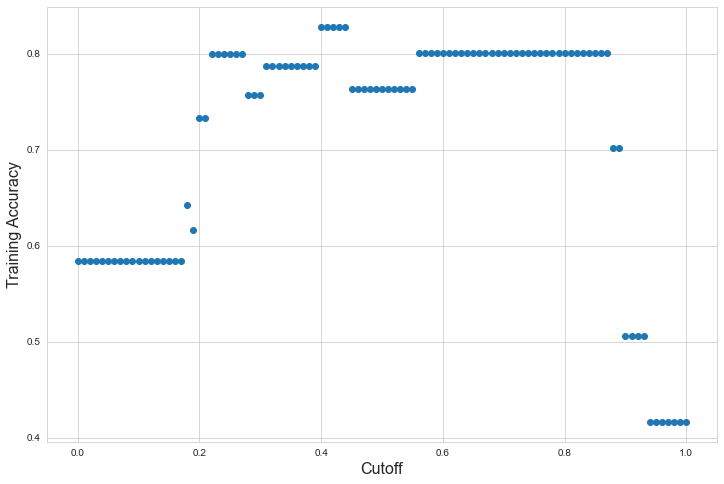

In [67]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Accuracy",fontsize=16)

plt.show()

In [68]:
Y_test_prob = log_reg.predict_proba(X_test)[:, 1]
accs_test = []
for cutoff in cutoffs:
    Y_test_pred = 1*(Y_test_prob>cutoff)
    accs_test.append(np.sum(Y_test_pred==Y_test)/len(Y_test))

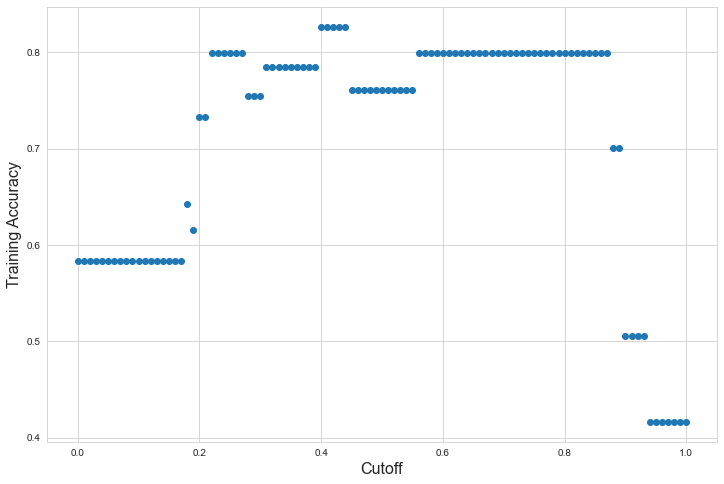

In [69]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,accs_test)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Accuracy",fontsize=16)

plt.show()

In [121]:
date_merged = bridge.merge(dim_claims, on=['dim_claim_id'], how='outer').merge(dim_date, on=['dim_date_id'], how='outer')
date_merged = date_merged[date_merged.dim_claim_id.notnull()]

In [122]:
date_merged.tail()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
1335571,1335572.0,555950.0,1095,417740.0,C,75.0,0.0,2019-12-31,2019,12,31,3,1,1,0
1335572,1335573.0,NaN,1095,999001.0,C,NaN,1.0,2019-12-31,2019,12,31,3,1,1,0
1335573,1335574.0,555951.0,1095,417380.0,C,70.0,0.0,2019-12-31,2019,12,31,3,1,1,0
1335574,1335575.0,NaN,1095,999001.0,C,NaN,1.0,2019-12-31,2019,12,31,3,1,1,0
1335575,1335576.0,NaN,1095,999001.0,C,NaN,1.0,2019-12-31,2019,12,31,3,1,1,0


In [72]:
claim_2017 = date_merged.loc[date_merged['calendar_year']==2017]

In [73]:
claim_2017.tail()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
384655,384656.0,159435.0,365,999001.0,C,76.0,0.0,2017-12-31,2017,12,31,1,0,0,0
384656,384657.0,159436.0,365,417740.0,C,75.0,0.0,2017-12-31,2017,12,31,1,0,0,0
384657,384658.0,159437.0,365,999001.0,C,76.0,0.0,2017-12-31,2017,12,31,1,0,0,0
384658,384659.0,NaN,365,999001.0,C,NaN,1.0,2017-12-31,2017,12,31,1,0,0,0
384659,384660.0,159438.0,365,999001.0,C,76.0,0.0,2017-12-31,2017,12,31,1,0,0,0


In [110]:
X_2017 = pd.get_dummies(data=claim_2017[['bin', 'drug']], columns=['bin', 'drug']).to_numpy()
Y_2017 = claim_2017['pharmacy_claim_approved'].to_numpy()

In [111]:
X_2017_train, X_2017_test, Y_2017_train, Y_2017_test = train_test_split(X_2017, Y_2017, test_size=0.25, random_state=614, shuffle=True, stratify= Y_2017)

In [112]:
log_reg_2017 = LogisticRegression()

In [113]:
log_reg_2017.fit(X_2017_train, Y_2017_train)

LogisticRegression()

In [114]:
accs_2017_train = []
X_2017_train_prob = log_reg.predict_proba(X_2017_train)[:,1]
for cutoff in cutoffs:
    Y_2017_train_pred = 1*(X_2017_train_prob>cutoff)
    accs_2017_train.append(np.sum(Y_2017_train_pred==Y_2017_train)/len(Y_2017_train))


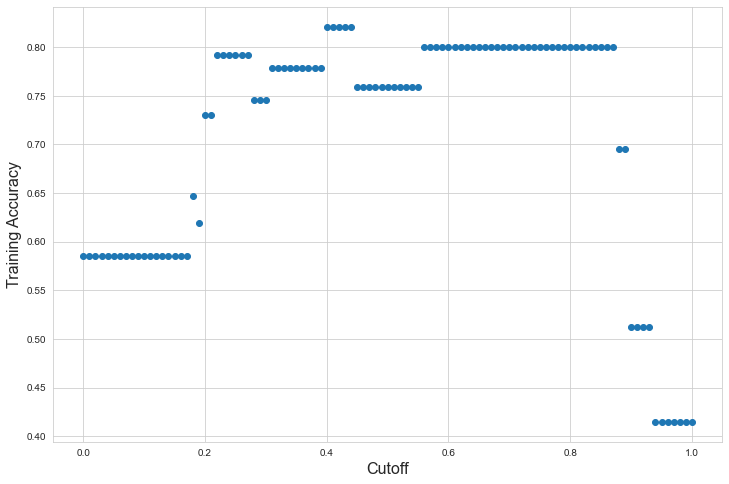

In [115]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,accs_2017_train)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Accuracy",fontsize=16)

plt.show()

## Decision Tree method

In [107]:
## Import decision tree classifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [108]:
tree_clf = DecisionTreeClassifier(random_state=614)

In [123]:
X_tree = pd.get_dummies(data=date_merged[['bin', 'drug', 'dim_date_id']], columns=['bin', 'drug']).to_numpy()
Y_tree = date_merged['pharmacy_claim_approved'].to_numpy()

In [124]:
X_tree_train, X_tree_test, Y_tree_train, Y_tree_test = train_test_split(X_tree, Y_tree, test_size=0.25, random_state=614, shuffle=True, stratify= Y_tree)

In [131]:
tree_clf.fit(X_tree_train, Y_tree_train)

DecisionTreeClassifier(random_state=614)

In [130]:
##plot decision tree
fig = plt.figure(figsize = (10,10))
tree.plot_tree(tree_clf,filled = True)
plt.show()

KeyboardInterrupt: 